# Gaussian Processes

In [155]:
# =======================================================
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:,.2f}".format

# ML Libraries
# =======================================================
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor


## Data

In [109]:
def read_dataset():
    
       url = "https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv" 
       data = pd.read_csv(url, sep=',')

       data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
       data = data.set_index('Time')
       data = data.asfreq('30min')
       data = data.sort_index()
       data = data.drop(columns='Date')
       data = data.resample(rule='D', closed='left', label ='right').agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})
       
       # Normalize Holiday 
       data["Holiday"] = data["Holiday"].astype(int)
       
       return data 

data = read_dataset()
data

,Demand,Temperature,Holiday
Time,,,
2012-01-01,"82,531.75",21.05,1
2012-01-02,"227,778.26",26.58,1
2012-01-03,"275,490.99",31.75,1
2012-01-04,"258,955.33",24.57,0
2012-01-05,"213,792.38",18.19,0
...,...,...,...
2014-12-28,"173,292.33",18.19,0
2014-12-29,"196,116.23",24.54,0
2014-12-30,"188,570.26",17.68,0


In [206]:
ts_variable = "Demand"
exo_variables = ["Temperature", "Holiday"]

In [231]:
df

,Demand,Temperature,Holiday,time_variable
Time,,,,
2014-10-01,0.86,12.66,0,271.00
2014-10-02,0.88,12.44,0,272.00
2014-10-03,0.85,13.77,0,273.00
2014-10-04,0.71,14.07,0,274.00
2014-10-05,0.53,19.94,0,275.00
...,...,...,...,...
2014-12-28,0.50,18.19,0,358.00
2014-12-29,0.66,24.54,0,359.00
2014-12-30,0.61,17.68,0,360.00


In [285]:
# init_date = '2014-01-01 00:00:00' 
# end_date = '2015-01-01 00:00:00'

init_date = '2014-10-01 00:00:00' 
end_date = '2015-01-01 00:00:00'

df = data.loc[init_date:end_date].copy()
df["time_variable"] = (df.index.year * 12 * 30 + df.index.month * 30 + df.index.day - 725070).astype(float)

# Shuffle the dataset 
np.random.seed(666)
df_shuffle = pd.concat([df[0:50].sample(30) , df[50:].sample(10)])

print(f'{df.shape = }')

df.shape = (93, 4)


Text(0, 0.5, 'Demand')

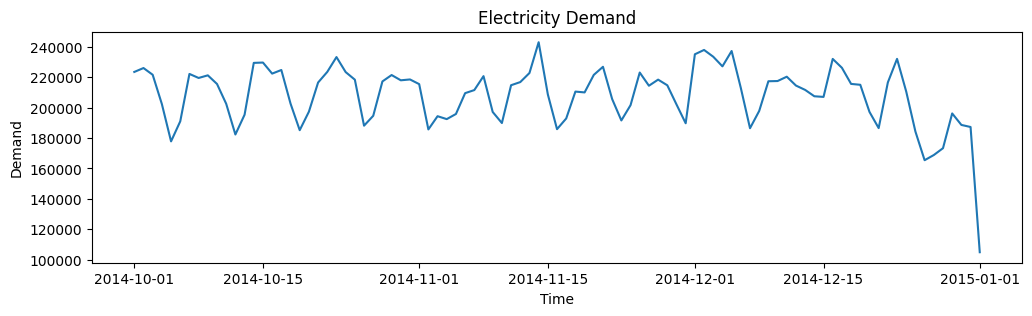

In [287]:
plt.figure(figsize = (12,3))
plt.plot(df.index, df[ts_variable])
plt.title("Electricity Demand")
plt.xlabel("Time")
plt.ylabel("Demand")

## Different Kernels

### RBF

In [288]:
seasonal_kernel = (
    ExpSineSquared(length_scale=1, periodicity=10)
)


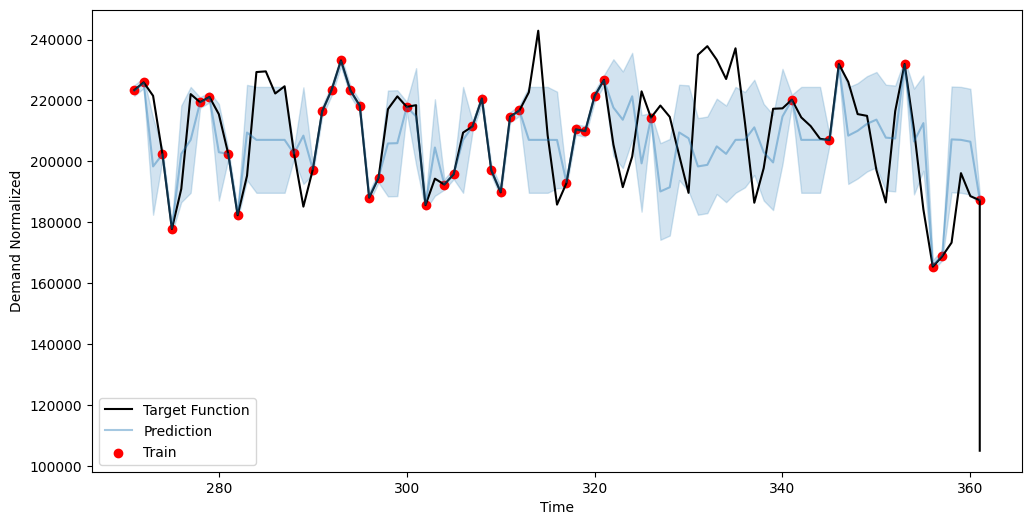

,Demand,Temperature,Holiday,time_variable,mean_pred,std_pred
Time,,,,,,
2014-10-01,"223,372.81",12.66,0,271.00,"223,231.40","1,728.28"
2014-10-02,"225,932.94",12.44,0,272.00,"225,745.94","1,729.99"
2014-10-03,"221,515.21",13.77,0,273.00,"198,324.91","15,865.94"
2014-10-04,"202,273.69",14.07,0,274.00,"202,320.88","1,729.99"
2014-10-05,"177,770.44",19.94,0,275.00,"178,047.02","1,728.28"
...,...,...,...,...,...,...
2014-12-28,"173,292.33",18.19,0,358.00,"207,192.86","17,377.90"
2014-12-29,"196,116.23",24.54,0,359.00,"207,052.32","17,386.23"
2014-12-30,"188,570.26",17.68,0,360.00,"206,439.96","17,379.21"


In [296]:
def train_gp(kernel, n_data):

    df_sample = df_shuffle[:n_data].copy()
    X_train = df_sample["time_variable"].values.reshape(-1, 1)
    y_train = df_sample[ts_variable].values

    # Fit
    gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha = 1e-2, normalize_y=True)
    gaussian_process.fit(X_train, y_train)

    # Predict 
    X_all = df["time_variable"].values.reshape(-1, 1)
    mean_y_pred, std_y_pred = gaussian_process.predict(X_all, return_std=True) 

    return mean_y_pred, std_y_pred 

def plot_gp_results(mean_y_pred, std_y_pred, n_data):

    df_sample = df_shuffle[:n_data].copy()
    X_train = df_sample["time_variable"].values.reshape(-1, 1)
    y_train = df_sample[ts_variable].values

    plt.figure(figsize=(12,6))
    plt.xlabel("Time")
    plt.ylabel("Demand Normalized")
    plt.plot(df["time_variable"], df[ts_variable], label="Target Function", color = "black")

    df["mean_pred"] = mean_y_pred 
    df["std_pred"] = std_y_pred 
    # df_drop = df.loc[df.mean_pred > 0.0].copy() 
    df_drop = df.copy()

    plt.plot(df_drop["time_variable"], df_drop["mean_pred"], color="tab:blue", alpha=0.4, label="Prediction")
    plt.fill_between(df_drop["time_variable"], df_drop["mean_pred"] - df_drop["std_pred"], df_drop["mean_pred"] + df_drop["std_pred"], color="tab:blue", alpha=0.2)
    plt.scatter(X_train, y_train, label="Train", color = "red")
    plt.legend()
    plt.show() 

    return df_drop

n_data = 1000
mean_y_pred, std_y_pred = train_gp(seasonal_kernel, n_data)
plot_gp_results(mean_y_pred, std_y_pred, n_data)



In [281]:
mean_y_pred

array([0.68356868, 0.68356868, 0.68356866, 0.68356863, 0.6835686 ,
       0.68356859, 0.68356861, 0.68356863, 0.68356866, 0.68356868,
       0.68356868, 0.68356866, 0.68356863, 0.6835686 , 0.68356859,
       0.68356861, 0.68356863, 0.68356866, 0.68356868, 0.68356868,
       0.68356866, 0.68356863, 0.6835686 , 0.68356859, 0.68356861,
       0.68356863, 0.68356866, 0.68356868, 0.68356868, 0.68356865,
       0.68356863, 0.68356863, 0.6835686 , 0.68356859, 0.68356861,
       0.68356863, 0.68356866, 0.68356868, 0.68356868, 0.68356865,
       0.68356862, 0.6835686 , 0.6835686 , 0.68356861, 0.68356864,
       0.68356866, 0.68356868, 0.68356867, 0.68356865, 0.68356862,
       0.6835686 , 0.6835686 , 0.68356861, 0.68356864, 0.68356866,
       0.68356868, 0.68356867, 0.68356865, 0.68356862, 0.6835686 ,
       0.6835686 , 0.68356861, 0.68356864, 0.68356866, 0.68356868,
       0.68356867, 0.68356865, 0.68356862, 0.6835686 , 0.6835686 ,
       0.68356861, 0.68356864, 0.68356867, 0.68356868, 0.68356

In [202]:
mean_y_pred

array([     0.        , 225930.68187318,      0.        , 202271.66820132,
       177768.66610934,      0.        , 222067.39182608, 219410.33508065,
       221137.97312027, 215471.00499595, 202450.55926641,      0.        ,
       195267.71174288,      0.        ,      0.        , 222270.27744323,
            0.        , 202592.04097159, 185116.88752712, 197277.13418666,
            0.        , 223407.4501195 , 233133.88499115, 223273.73267467,
            0.        , 188064.36661033,      0.        ,      0.        ,
            0.        , 217879.90625294, 215363.71763282, 215363.71763282,
       185612.12326277,      0.        , 192381.74632654, 195755.03714163,
            0.        , 211454.0897771 , 220605.22790572,      0.        ,
       189807.54484055, 214644.10185098,      0.        , 222671.66331537,
       242887.17539425,      0.        ,      0.        ,      0.        ,
            0.        , 209919.31351886, 221428.91585684,      0.        ,
       205535.23089569, 1